
# Creation of a quantization, use and evaluation pipeline, featuring LLaMA2 7B model and BitsAndBytes

In this notebook, we evaluate the impact quantization has in a common use LLM model, in our case LLaMA 2 7B, evaluating it in a sentiment analysis task. Our pipeline is defined as follows:
- Add a classification layer at the end of the not-quantized model and train this new model with our dataset.
- Quantize the model using **BitsAndBytes** in both of its variants, 8bit and 4 bit quantization.
- Compare the performance of our models (not quantized, 4bits and 8bits) in terms of precission, memory use, inference speed and emissions.

![Pipeline Diagram](./BitsAndBytes_Pipeline.png)

We follow this approach because it is the easiest approach to follow. Another option would be to firstly quantize the base model and then add the classification layer and train it. In fact, one could think this approach is better than the previously exposed. However, lots of problems are encountered doing this, because fine tuning an already quantized model is not a good practice. 

### Goals
1. Analize the impact quantization has on performance.
2. Compare the efficiency and precision of the quantized models with the not-quantized model.


## BitsAndBytes

Bitsandbytes is an optimized library for quantizing deep learning models, developed by Tim Dettmers, a researcher specializing in optimization and efficiency in Deep Learning. Its primary goal is to make computations in large models more efficient by allowing the use of lower precision operations, leading to reduced memory usage and faster training and inference processes. Bitsandbytes is widely used in the quantization of large matrices and vectors, offering support for 8-bit, 4-bit, and even mixed-precision quantization. Inside all quantization methods, this one is inside the PTQ (post-training quantization) category. Specifically for the 4 bit variant, it leverages a novel data type called 4-bit NormalFloat (NF4), which is theoretically optimal for representing normally distributed weights.

The main idea BitsAndBytes follows to perform quantization is identifying the outliers. These values are data points or weights in the model that have unusually high or low values compared to the rest of the data. Considering the idea that these values are uncommon to find, BitsAndBytes keeps them in 16-bit float precission, helping to mantain a higher precission. All the other data points, the non-outliers, are converted to 8-bit or 4-bit integer format, depending of the quantization type. With this, after the final step of the quantization method, the non-outlier values are converted back 16-bit float precission. This is done to mantain a uniform data type and help the integration and processing of the weights. In summary, BitsAndBytes detects the outliers and keeps them in high precission data types to mantanin accuracy and reduces the precission of all the other values, which are the most common ones, to reduce the memory footprint of the model.

It is clear that given the explanation of this method, outliers are critical. Therefore, one may ask "How are outliers defined? What is the percentage of these in our model?". These are legit questions and we will try to answer them. First of all, the amount of outliers depends on the model and configuration of BitsAndBytes used, because the definition changes. For example, in a 8bit BitsAndBytes configuration, the outlier threshold is set to 6 (in absolute value) by default. Although this value typically works well, for some big models it may not be appropiate. For this reason, this value can be changed by using the *llm_int8_threshold* parameter when creating the configuration. Different experiments have shown that outliers typically represent below 1% of the values, but still can be very critical in some layers. To know the exact amount in our specific case, we should perform a layer by layer analysis of our quantized model. This experiment will also help to decide which threshold suits best the model after comparing different threshold configurations.

Finally, regarding the inference process, we mentioned that BitsAndBytes reduces the precission of "normal" values but keeps the outliers in high precission. Inference is performed using mixed matrices and specific CUDA kernels to perform the operations correctly in this scenario. Therefore, "normal" weights and outliers are procesed separately and combined at the end to obtain the end result.

## Hardware and software

### Hardware
- CPU: Intel(R) Xeon(R) Silver 4316 CPU @ 2.30GHz
- RAM: 985 GB
- GPU: NVIDIA A100-PCIE-40GB
### Software
For this project, we used the following python libraries: torch, transformers, time and datasets, among others. Of course, all the libraries that these libraries have dependencies with are needed too.
We also used some other libraries or tools that help to evaluate the results. For example, the library CodeCarbon was used to collect emissions data, and the Weights and Biases (Wandb) platform was used to collect and visualize metrics. 


## Project pipeline

### 1. Base model preparation
The base model used is **LLaMA 2 (7B)**. We added a classifier layer to it by loading it with the LlamaForSequenceClassification function from the Transformers library. Then, fine tuning was performed using the **TweetEval** dataset, focusing on the sentiment classification task on its training subset. To make the fine-tuning more efficient and lightweight, Low-Rank Adaptation (LoRA) was applied to the attention layers using the PEFT library, reducing the number of trainable parameters. Training was carried out on a single  NVIDIA A100 40GB GPU using the Hugging Face ***Trainer*** API with a learning rate of $2 \times 10^{-5}$, a batch size of 8, and a total of 3 epochs.

### 2. Quantization 
Quantization was performed using **bitsandbytes**. This quantization method offers 2 quantization options: **8 bits** and **4 bits**.
This leads us to have 3 different models: **quantized to 8 bits**, **quantized to 4 bits** and **not quantized**.

### 3. Evaluation
These three models were evaluated and compared in terms of: **accuracy**, **macro F1 score**, **memory use**, **inference speed** and **emissions**. The dataset used was the same we used for the training before, but we used the test subset.


## Results

### Accuracy and F1 score results
We now show the results obtained for the accuracy of each of the three models:

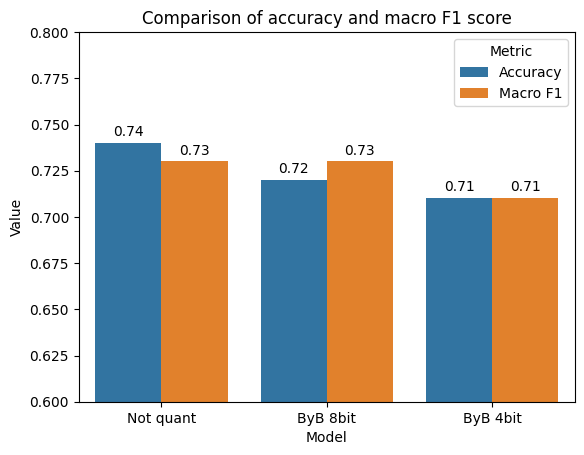

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant', 'ByB 8bit', 'ByB 4bit'],
    'Accuracy': [0.74, 0.72, 0.71],
    'Macro F1': [0.73, 0.73, 0.71]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of accuracy and macro F1 score')
plt.ylim(0.6, 0.8)
plt.show()


We observe how the accuracy is higher with the base model and, between the quantized models, the 8-bit variant has a higher accuracy, although differences are minimal, not only between the quantized models, but also betweem them and the base model. 


### Memory use results

Measuring memeory needs is not an easy task. We decided to check the maximum memory need while inference (in GPU). Note that this measure tends to be higher due to needs associated with inference, specially when using batches.

We only measured this and not the disk memory required because of the way we store the models. Since we used LoRA to fine tune and train our base model with the classification layer, we don't store the whole model explicitly, but only the LoRA adpaters generated. Therefore, we are unable to compare additional memory usage metrics, such as disk memory requirements.

Now we show the maximum memory needed for inference for each model and inference configuration:

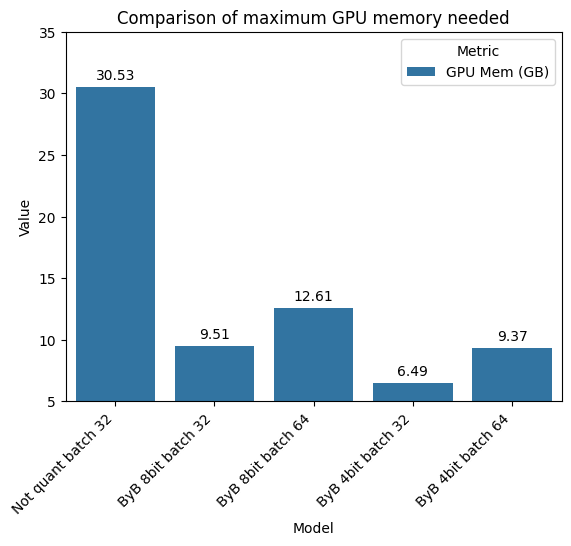

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant batch 32', 'ByB 8bit batch 32', 'ByB 8bit batch 64', 'ByB 4bit batch 32', 'ByB 4bit batch 64'],
    'GPU Mem (GB)': [30.53, 9.51, 12.61, 6.49, 9.37]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of maximum GPU memory needed')
plt.ylim(5.0, 35.0)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how the maximum memory usage in GPU during inference increases with batch size for all models. The bigger the batch size, the higher the memory needs. In addition to this, we see how the base model needs considerable more memory compared to both quantized models, and between the quantized models, the 4bit variant requires less memory than the 8bit one.

### Inference speed results

In this section we show the results obtained for inference time and quantization time:  

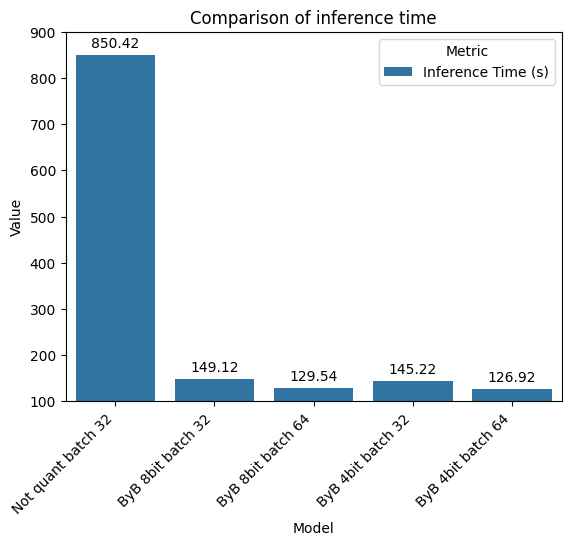

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant batch 32', 'ByB 8bit batch 32', 'ByB 8bit batch 64', 'ByB 4bit batch 32', 'ByB 4bit batch 64'],
    'Inference Time (s)': [850.42, 149.12, 129.54, 145.22, 126.92]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of inference time')
plt.ylim(100.0, 900.0)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how, with a big difference, the base model is the slowest one. All the quantized models are faster and between them, the 4bit variant seems a little faster, but with a small difference. The use of a bigger batch size also shows improvement in speed but difference is not specially big.

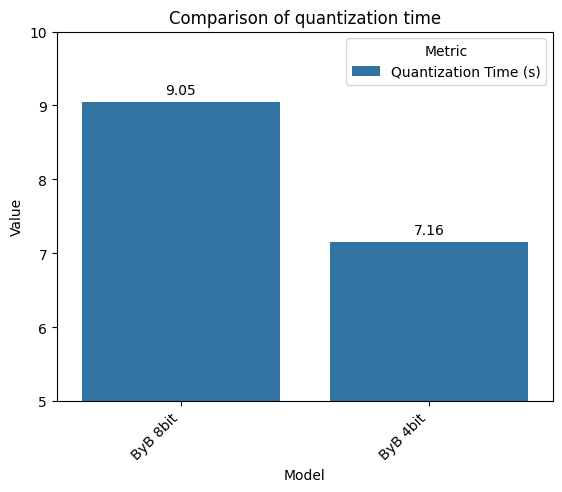

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['ByB 8bit', 'ByB 4bit'],
    'Quantization Time (s)': [9.052, 7.156]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of quantization time')
plt.ylim(5.0, 10.0)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how the 4bit variant needs less time to be quantized, although differce is small. However, as we are working with small numbers, in percentage the 8bit model is 26.39% slower than the 4bit variant during quantization.

### Emissions results

The emissions are a little challenging to measure and compare. This is because we need to decide if we take into account the emissions generated during the quantization of the models. Our approach will show the resuts obtained for evaluation separated from the emissions for the quantization process, but will take them into consideration when comparing. We will measure the emissions of CO<sub>2</sub> in kilograms of CO<sub>2</sub>-equivalents \[CO<sub>2</sub>eq\]

The emissions generated by the evaluation process and the quantization were:


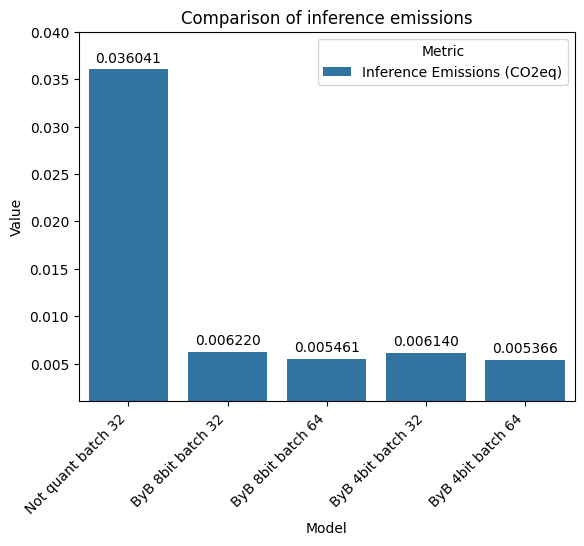

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant batch 32', 'ByB 8bit batch 32', 'ByB 8bit batch 64', 'ByB 4bit batch 32', 'ByB 4bit batch 64'],
    'Inference Emissions (CO2eq)': [0.036041, 0.006220, 0.005461, 0.006140, 0.005366]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.6f', padding=3)
plt.title('Comparison of inference emissions')
plt.ylim(0.001, 0.04)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how, following the same trend shown in speed results, the base model has bigger emissions than both quantized models. Between these, differences are minimal but the 4bit variant has slightly lower emissions. Batch size also affects, with higher batch sizes having lower emissions.

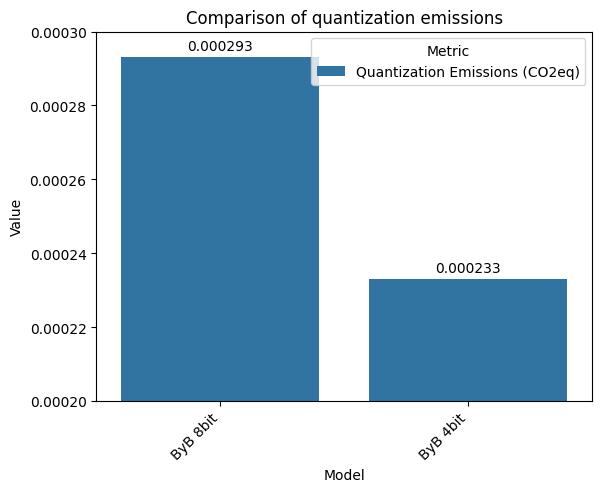

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['ByB 8bit', 'ByB 4bit'],
    'Quantization Emissions (CO2eq)': [0.000293, 0.000233]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.6f', padding=3)
plt.title('Comparison of quantization emissions')
plt.ylim(0.0002, 0.0003)
plt.xticks(rotation=45, ha='right')
plt.show()

Again, quantization emissions results follow the same trend seen before with quantization time results. The 4bit variant has lower emissions than the 8bit variant. In fact, the 8bit variant has 25.75 higher emissions than the 4bit one during quantization.


## Conclusions

Results show that:

1. Quantization does in fact reduce accuracy, and the lower the bit count, the higher this drop is. However, the drop with **BitsAndBytes** is not as significant, as we saw. Accuracy remains very close to the base model results. 
2. Both quantized models are noticeably better in terms of memory usage compared to the base model.
3. Quantized models with **BitsAndBytes** are faster than the base model.
4. In a similar fashion as inference time, emissions are lower in the quantized models. This is coherent with the fact that the inference time is lower. 

